In [15]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import infovar

sys.path.insert(0, os.path.join("..", ".."))
sys.path.insert(1, os.path.join(".."))

from infobs.plots import Plotter
from orion_util import load_integral, load_param, plot_map, latex_line, latex_param 

# plt.rc("text", usetex=True)
data_dir = os.path.join("..", "data", "continuous")
figures_dir = os.path.join("continuous_images_comparison_comb")

%matplotlib widget
# Instead of matplotlib notebook in VS Code

In [22]:
handler = infovar.ContinuousHandler()
handler.set_paths(
    save_path=os.path.join("..", "data", "continuous", "results")
)

In [23]:
plotter = Plotter(
    line_formatter=latex_line,
    param_formatter=latex_param
)

latex_comb_lines = lambda ls: plotter.lines_comb_formatter(ls, short=True)
latex_comb_params = lambda ps: plotter.params_comb_formatter(ps)

## Settings

In [24]:
lims = {
    'av': [1e+0, 8e+1],
    'g0': [None, None]
}

win_width = [20, 20] # In percents

In [28]:
params_target = "av"            # Can be "av", "g0" or ["av", "g0"]
params_regime = ["av", "g0"]    # Cannot be modified
lines = ["12co10", "13co10", "c18o10", "hcop10", "n2hp10"]
line_ref = "13co10"

stat = "mi"

In [29]:
ticksfontsize = 14
labelfontsize = 16
titlefontsize = 16

In [32]:
d = handler.read(
    lines, params_target, params_regime
)
xticks, yticks = d["stats"][stat]['coords']
mat = d["stats"][stat]['data'].T

def plot_picker(xticks, yticks, mat):
    X, Y = np.meshgrid(xticks, yticks)

    # First marginal

    fig, ax = plt.subplots(1, 1, dpi=100)

    ax.pcolor(X, Y, mat, cmap='jet', vmin=0)
    ax.set_xlim(lims[params_regime[0]])
    ax.set_ylim(lims[params_regime[1]])

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(f"${plotter.param_formatter(params_regime[0])}$", fontsize=labelfontsize)
    ax.set_ylabel(f"${plotter.param_formatter(params_regime[1])}$", fontsize=labelfontsize)
    ax.set_title(f"${plotter.lines_comb_formatter(lines)}$", fontsize=titlefontsize, pad=15)

    ax.tick_params(axis='both', labelsize=ticksfontsize)

    return fig, ax

In [33]:
integ_ref, header_ref = load_integral(line_ref)
vmin_ref = 0.
vmax_ref = integ_ref.max()

params = [load_param(name) for name in params_regime]

In [34]:
def get_mask(
    v1: int, v2: int
):
    # params: List[Tuple]
    widths = [perc/100 * np.ptp(np.log10(p)) for (p, _), perc in zip(params, win_width)]
    vals = [v1, v2]

    mask = np.ones_like(params[0][0], dtype=bool)
    for k, (p, _) in enumerate(params):
        mid = np.log10(vals[k])
        mask &= (mid-widths[k]/2 <= np.log10(p)) & (np.log10(p) <= mid+widths[k]/2)

    return mask

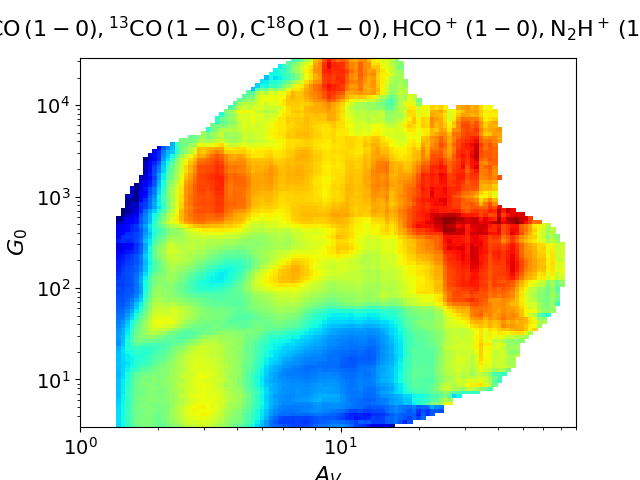

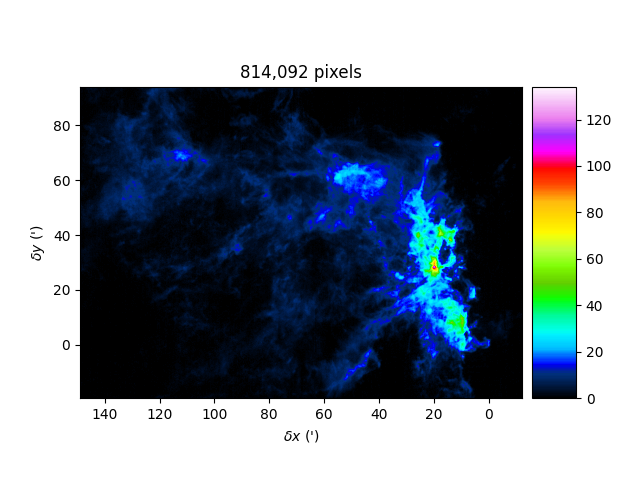

In [35]:
# For non-interactive mode (can be modified)
i, j = 0, 0
mask = np.zeros_like(integ_ref, dtype=bool)
    
# Coordinates picker
    
figPicker, axPicker = plot_picker(xticks, yticks, mat)
    
# Display profile
    
figRef, axRef = plt.subplots(1, 1)
im, _, __ = plot_map(integ_ref, header_ref, ax=axRef, vmin=vmin_ref, vmax=vmax_ref)
axRef.set_title(f"{mask.size:,} pixels")

# Asynchronous event handling

def onclick(event):
    v1, v2 = int(event.xdata), int(event.ydata)
    mask = get_mask(v1, v2)
    data = np.where(mask, np.nan, integ_ref)
    axRef.set_title(f"{mask.sum():,} pixels")
    im.set_data(data)
    figRef.canvas.draw_idle()

cid = figPicker.canvas.mpl_connect('button_press_event', onclick)

# Plot box to indicate the limits of the sliding windows, on click (figPicker)